In [30]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, MaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import itertools

In [31]:
TRAINING_DIR = 'config/letras/train'
TEST_DIR = 'config/letras/test'
num_classes = 9
batch_size = 32
image_size = (64, 64)

# Load and preprocessing data

In [32]:
train_data = tf.keras.utils.image_dataset_from_directory(TRAINING_DIR)
test_data = tf.keras.utils.image_dataset_from_directory(TEST_DIR)

Found 5403 files belonging to 9 classes.
Found 2762 files belonging to 9 classes.


In [33]:
data_iterator = train_data.as_numpy_iterator()
batch = data_iterator.next()

In [34]:
from pathlib import Path

image_dir_path = 'config/letras/train'
paths = [path.parts[-2:] for path in
         Path(image_dir_path).rglob('*.jpg')]
df = pd.DataFrame(data=paths, columns=['Class', 'Image'])

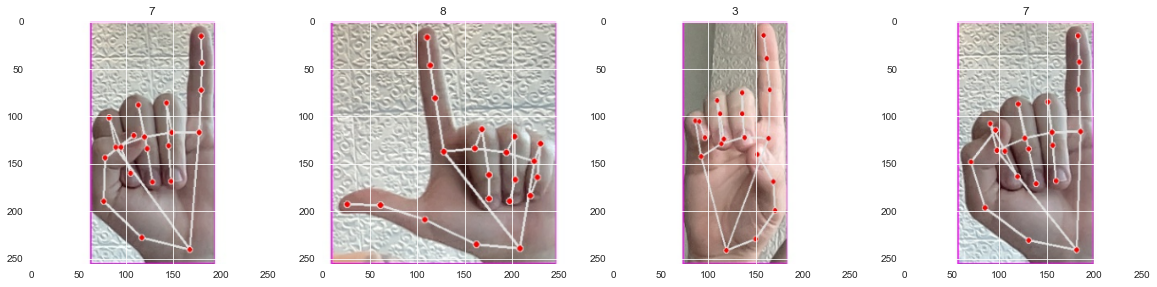

In [35]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5403 entries, 0 to 5402
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Class   5403 non-null   object
 1   Image   5403 non-null   object
dtypes: object(2)
memory usage: 84.5+ KB


In [37]:
df.head()

,Class,Image
0,I,Image_193.jpg
1,I,Image_187.jpg
2,I,Image_178.jpg
3,I,Image_150.jpg
4,I,Image_144.jpg


# Data Visualization

In [38]:
print(train_data.class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L']


<Axes: xlabel='Class', ylabel='count'>

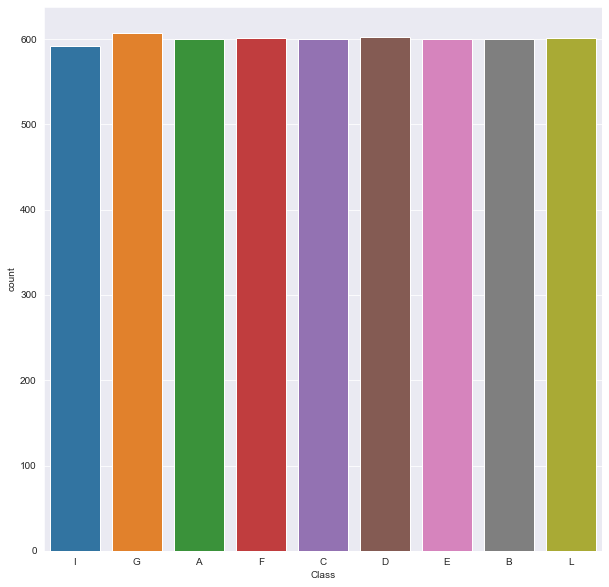

In [39]:
plt.figure(figsize = (10,10)) # Label Count
sns.set_style("darkgrid")
sns.countplot(data=df, x='Class')

# Data Augmentation

In [40]:
datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,     # randomly flip images
        validation_split=0.2) 

testDatagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,     # randomly flip images
        validation_split=0.0) 

In [41]:
train_generator = datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=image_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

validation_generator = datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=image_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

test_generator = testDatagen.flow_from_directory(
    TEST_DIR,
    target_size=image_size,
    color_mode='grayscale',
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')

Found 4324 images belonging to 9 classes.
Found 1079 images belonging to 9 classes.
Found 2762 images belonging to 9 classes.


# Building Model

In [42]:
def create_model():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=4, strides=1, activation='relu', input_shape=(64, 64, 1)))
    model.add(Conv2D(64, kernel_size=4, strides=2, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(128, kernel_size=4, strides=1, activation='relu'))
    model.add(Conv2D(128, kernel_size=4, strides=2, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(256, kernel_size=4, strides=1, activation='relu'))
    model.add(Conv2D(256, kernel_size=4, strides=2, activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(9, activation='softmax'))
    model.compile(optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [43]:
model = create_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 61, 61, 64)        1088      
                                                                 
 conv2d_28 (Conv2D)          (None, 29, 29, 64)        65600     
                                                                 
 dropout_14 (Dropout)        (None, 29, 29, 64)        0         
                                                                 
 conv2d_29 (Conv2D)          (None, 26, 26, 128)       131200    
                                                                 
 conv2d_30 (Conv2D)          (None, 12, 12, 128)       262272    
                                                                 
 dropout_15 (Dropout)        (None, 12, 12, 128)       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 9, 9, 256)        

# Training

In [44]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)
early_stopping_cb = EarlyStopping(patience = 5)

In [45]:
hist = model.fit(train_generator, epochs=5, validation_data=validation_generator, callbacks=[learning_rate_reduction,early_stopping_cb])

Epoch 1/5
136/136 [==============================] - 68s 493ms/step - loss: 2.0013 - accuracy: 0.2206 - val_loss: 1.5111 - val_accuracy: 0.3753 - lr: 0.0010
Epoch 2/5
136/136 [==============================] - 69s 505ms/step - loss: 0.6626 - accuracy: 0.7690 - val_loss: 0.3363 - val_accuracy: 0.8730 - lr: 0.0010
Epoch 3/5
136/136 [==============================] - 67s 496ms/step - loss: 0.2933 - accuracy: 0.8973 - val_loss: 0.2057 - val_accuracy: 0.9379 - lr: 0.0010
Epoch 4/5
136/136 [==============================] - 72s 528ms/step - loss: 0.1651 - accuracy: 0.9387 - val_loss: 0.1319 - val_accuracy: 0.9527 - lr: 0.0010
Epoch 5/5
136/136 [==============================] - 68s 501ms/step - loss: 0.1292 - accuracy: 0.9565 - val_loss: 0.1832 - val_accuracy: 0.9388 - lr: 0.0010


In [46]:
# model.save(os.path.join('./model','imageclassifier9lettersV2_2.h5'))

# Performance

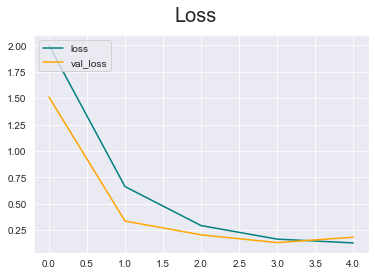

In [47]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

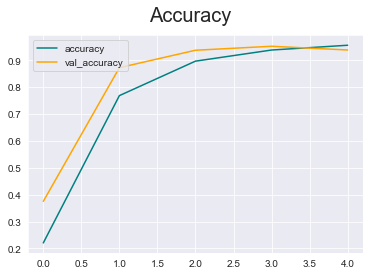

In [48]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Test

In [49]:
model = load_model('model/imageclassifier9lettersV2_2.h5')

1/1 [==============================] - 0s 117ms/step
0
Class - A


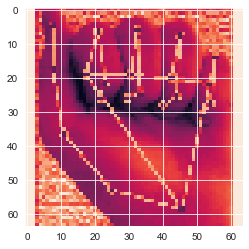

In [50]:
classes = ["A", "B", "C", "D", "E", "F", "G", "I", "L"]

# Load and preprocess the test image
test_image_path = 'config/letras/test/A/Image_100.jpg'

# Load the image and convert it to an array
test_image = load_img(test_image_path, target_size=image_size, color_mode="grayscale")

plt.figure()
plt.imshow(test_image)

test_image = img_to_array(test_image)

# Reshape and normalize the image
test_image = np.expand_dims(test_image, axis=0)
test_image /= 255.0

# Make predictions on the test image
predictions = model.predict(test_image)
predicted_class = np.argmax(predictions, axis=1)
index = predicted_class[0]
print(index)
print('Class - {}'.format(classes[index]))

In [51]:
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

87/87 [==============================] - 14s 154ms/step - loss: 0.3566 - accuracy: 0.8671
Test loss: 0.35662078857421875
Test accuracy: 0.8671252727508545


In [52]:
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

87/87 [==============================] - 12s 139ms/step
Classification Report
              precision    recall  f1-score   support

           A       0.97      0.97      0.97       303
           B       0.74      0.98      0.84       306
           C       0.99      0.87      0.92       305
           D       0.98      0.62      0.76       310
           E       0.93      0.91      0.92       306
           F       0.70      0.88      0.78       305
           G       0.97      0.84      0.90       311
           I       0.79      0.73      0.76       309
           L       0.87      0.99      0.92       307

    accuracy                           0.86      2762
   macro avg       0.88      0.87      0.86      2762
weighted avg       0.88      0.86      0.86      2762



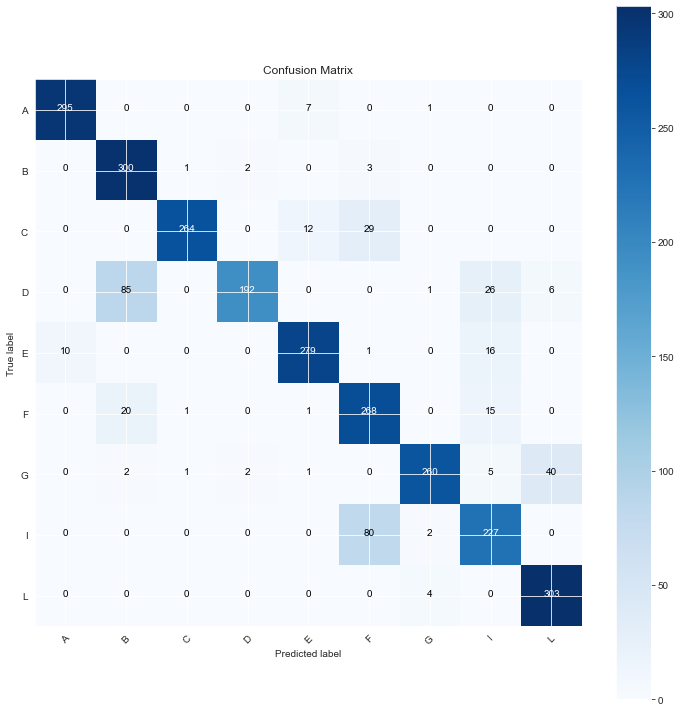

In [53]:
#On test dataset
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = list(train_generator.class_indices.keys())

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

#Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))